In [1]:
import sys
sys.path.append('../')

In [2]:
import datetime
import os
import time

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision as tv
import torchvision.datasets as datasets
from art.attacks.evasion import BasicIterativeMethod
from art.estimators.classification import PyTorchClassifier
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

from region_based_classifier import RegionBasedClassifier
from util import dataset2tensor, get_correct_examples

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device: {}'.format(device))

n_threads = os.cpu_count()
print('CPU threads: {}'.format(n_threads))

Device: cuda
CPU threads: 24


In [5]:
PATH_DATA = os.path.join('..', 'data')
PATH_RESULTS = os.path.join('..', 'results', 'mnist_base_model.pt')
BATCH_SIZE = 128
EPOCHS = 50
N_ADV = 2000

In [6]:
# Fetch dataset
transforms = tv.transforms.Compose([tv.transforms.ToTensor()])
dataset_train = datasets.MNIST(PATH_DATA, train=True, download=True, transform=transforms)
dataset_test = datasets.MNIST(PATH_DATA, train=False, download=True, transform=transforms)

# From PyTorch dataset to Numpy array
tensor_X_train, tensor_y_train = dataset2tensor(dataset_train)
X_train = tensor_X_train.cpu().detach().numpy()
y_train = tensor_y_train.cpu().detach().numpy()
tensor_X_test, tensor_y_test = dataset2tensor(dataset_test)
X_test = tensor_X_test.cpu().detach().numpy()
y_test = tensor_y_test.cpu().detach().numpy()

# Split model training set into training set and validation set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=5000)
dataset_train = TensorDataset(
    torch.tensor(X_train, dtype=torch.float32),
    torch.tensor(y_train, dtype=torch.int64))

dataloader_train = DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=True)
dataloader_test = DataLoader(dataset_test, batch_size=BATCH_SIZE, shuffle=True)

In [7]:
# Check sizes
print(X_train.shape, X_val.shape, X_test.shape)

(55000, 1, 28, 28) (5000, 1, 28, 28) (10000, 1, 28, 28)


## Train classifier

In [8]:
# Create Neural Network model
class BaseModel(nn.Module):
    def __init__(self):
        super(BaseModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.relu2 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2)
        self.flatten = nn.Flatten(1)
        self.fc1 = nn.Linear(9216, 200)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(200, 10)
        self.softmax = nn.Softmax(dim=1)

    def before_softmax(self, x):
        x = self.relu1(self.conv1(x))
        x = self.relu2(self.conv2(x))
        x = self.pool1(x)
        x = self.flatten(x)
        x = self.relu3(self.fc1(x))
        x = self.fc2(x)
        return x

    def forward(self, x):
        x = self.before_softmax(x)
        x = self.softmax(x)
        return x
    
    

In [9]:
# Testing outputs
model = BaseModel().to(device)
model.eval()
it = iter(dataloader_train)
x, y = next(it)
x = x.to(device)
output0 = model(x)
print(output0.size())

# The outputs are probabilities (sum to 1)
print(output0[:5].sum(dim=1))

torch.Size([128, 10])
tensor([1., 1., 1., 1., 1.], device='cuda:0', grad_fn=<SumBackward1>)


In [10]:
def train(model, loader, loss, optimizer):
    model.train()
    total_loss = 0.
    corrects = 0.
    
    for x, y in loader:
        x = x.to(device)
        y = y.to(device)
        batch_size = x.size(0)
        
        optimizer.zero_grad()
        outputs = model(x)
        l = loss(outputs, y)
        l.backward()
        optimizer.step()

        # for display
        total_loss += l.item() * batch_size
        preds = outputs.max(1, keepdim=True)[1]
        corrects += preds.eq(y.view_as(preds)).sum().item()
    
    n = len(loader.dataset)
    total_loss = total_loss / n
    accuracy = corrects / n
    return total_loss, accuracy

In [11]:
def validate(model, loader, loss, device=device):
    model.eval()
    total_loss = 0.
    corrects = 0.
    
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device)
            batch_size = x.size(0)
            outputs = model(x)
            l = loss(outputs, y)
            total_loss += l.item() * batch_size
            preds = outputs.max(1, keepdim=True)[1]
            corrects += preds.eq(y.view_as(preds)).sum().item()
    
    n = len(loader.dataset)
    total_loss = total_loss / n
    accuracy = corrects / n
    return total_loss, accuracy

In [12]:
def predict(model, X, batch_size=BATCH_SIZE, device=device):
    model.eval()
    dataset = TensorDataset(X)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    tensor_pred = -torch.ones(len(X), dtype=torch.int64)
    
    start = 0
    with torch.no_grad():
        for x in loader:
            x = x[0].to(device)
            n = x.size(0)
            end = start + n
            outputs = model(x)
            tensor_pred[start:end] = outputs.max(1)[1].type(torch.int64)
            start += n

    return tensor_pred

In [13]:
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
loss=nn.CrossEntropyLoss()

In [14]:
# DO NOT RUN THIS IF YOU DON'T NEED RETRAIN!
# since = time.time()
# for epoch in range(EPOCHS):
#     start = time.time()
#     tr_loss, tr_acc = train(model, dataloader_train, loss, optimizer)
#     va_loss, va_acc = validate(model, dataloader_test, loss)
    
#     time_elapsed = time.time() - start
#     print(('{:2d}/{:d}[{:s}] Train Loss: {:.4f} Acc: {:.4f}%, ' +
#         'Test Loss: {:.4f} Acc: {:.4f}%').format(
#             epoch+1, EPOCHS, str(datetime.timedelta(seconds=time_elapsed)),
#             tr_loss, tr_acc*100.,
#             va_loss, va_acc*100.))
    
# time_elapsed = time.time() - since
# print('Total run time: {:.0f}m {:.1f}s'.format(
#     time_elapsed // 60,
#     time_elapsed % 60))

# if not os.path.exists('results'):
#     os.makedirs('results')

# torch.save(model.state_dict(), PATH_RESULTS)

In [15]:
# Load model from saved file
model.load_state_dict(torch.load(PATH_RESULTS))

_, acc_test = validate(model, dataloader_test, loss)
print('Test set accuracy: {:.4f}'.format(acc_test*100))

Test set accuracy: 97.5800


## Remove missclassified samples

In [16]:
print('Training set: {}'.format(len(dataset_train)))
tensor_train_X, tensor_train_y = get_correct_examples(model, dataset_train, device=device, return_tensor=True)
dataset_train_perfect = TensorDataset(tensor_train_X, tensor_train_y)
dataloader_train_perfect = DataLoader(dataset_train_perfect, batch_size=512, shuffle=True)
_, acc = validate(model, dataloader_train_perfect, loss)
print('Accuracy on {} filtered training examples: {:.4f}%'.format(len(dataloader_train_perfect.dataset), acc*100))

print('Test set: {}'.format(len(dataset_test)))
tensor_test_X, tensor_test_y = get_correct_examples(model, dataset_test, device=device, return_tensor=True)
dataset_test_perfect = TensorDataset(tensor_test_X, tensor_test_y)
dataloader_test_perfect = DataLoader(dataset_test_perfect, batch_size=512, shuffle=True)
_, acc = validate(model, dataloader_test_perfect, loss)
print('Accuracy on {} filtered test examples: {:.4f}%'.format(len(dataloader_test_perfect.dataset), acc*100))

Training set: 55000
Accuracy on 54001 filtered training examples: 100.0000%
Test set: 10000
Accuracy on 9758 filtered test examples: 100.0000%


## Create adversarial examples 

In [17]:
classifier = PyTorchClassifier(
    model=model, 
    loss=loss, 
    input_shape=(1, 28, 28), 
    optimizer=optimizer,
    nb_classes=10,
    clip_values=(0.0, 1.0),
    device_type=device
)

# attack = FastGradientMethod(estimator=classifier, eps=0.3)
attack = BasicIterativeMethod(estimator=classifier, eps=0.3)

In [18]:
# Prepare dataset for adversarial examples
n = len(dataset_test_perfect)
indices = torch.randperm(n)[:N_ADV]

X_benign = tensor_test_X[indices].cpu().detach().numpy()
y_true = tensor_test_y[indices].cpu().detach().numpy()

In [19]:
# Predictions from benign samples
pred_benign = np.argmax(classifier.predict(X_benign), axis=1)

# Generate adversarial examples
X_adv = attack.generate(x=X_benign)
pred_adv = np.argmax(classifier.predict(X_adv), axis=1)

PGD - Batches:   0%|          | 0/63 [00:00<?, ?it/s]/home/lukec/.local/lib/python3.6/site-packages/art/estimators/classification/pytorch.py:525: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_grad = torch.tensor(x).to(self._device)
/home/lukec/.local/lib/python3.6/site-packages/art/estimators/classification/pytorch.py:526: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_grad = torch.tensor(y).to(self._device)


In [20]:
accuracy = np.sum(pred_benign == y_true) / float(len(pred_benign))
print("Model accuracy on clean examples: {:.4f}%".format(accuracy * 100))

accuracy = np.sum(pred_adv == y_true) / float(len(pred_adv))
print("Model accuracy on adversarial examples: {:.4f}%".format(accuracy * 100))

Model accuracy on clean examples: 100.0000%
Model accuracy on adversarial examples: 0.5500%


## MagNet

In [21]:
from torchvision.utils import make_grid
from magnet import (Autoencoder1, Autoencoder2, MagNetDetector, 
                    MagNetAutoencoderReformer, MagNetNoiseReformer, MagNetOperator)

In [22]:
PATH_DETECTOR = os.path.join('..', 'results', 'detector1.pt')

In [23]:
autoencoder1 = Autoencoder1(n_channel=1)
detector1 = MagNetDetector(
    encoder=autoencoder1,
    classifier=model,
    lr=0.001,
    batch_size=256,
    weight_decay=1e-09,
    x_min=0.0,
    x_max=1.0,
    noise_strength=0.025,
    algorithm='error',
    p=1,
    device=device)

In [24]:
detector1.fit(X_train, epochs=50, disable_progress_bar=False)

100%|██████████| 50/50 [00:53<00:00,  1.07s/it]


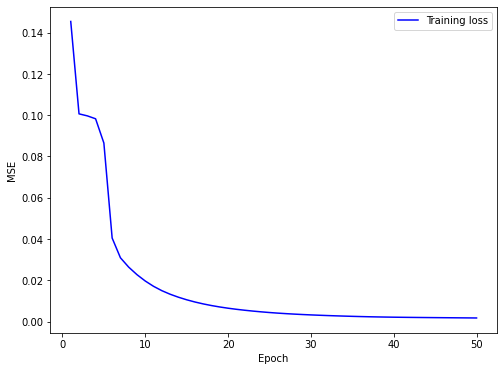

In [25]:
hitstory_loss = detector1.history_train_loss
n = len(hitstory_loss)

plt.figure(figsize=(8, 6))
x = np.arange(1, n+1)
plt.plot(x, hitstory_loss, c='blue', label='Training loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.show()

In [26]:
autoencoder2 = Autoencoder2(n_channel=1)
detector2 = MagNetDetector(
    encoder=autoencoder2,
    classifier=model,
    lr=0.001,
    batch_size=256,
    weight_decay=1e-09,
    x_min=0.0,
    x_max=1.0,
    noise_strength=0.025,
    algorithm='error',
    p=2,
    device=device)
detector2.fit(X_train, epochs=50, disable_progress_bar=False)

100%|██████████| 50/50 [00:36<00:00,  1.37it/s]


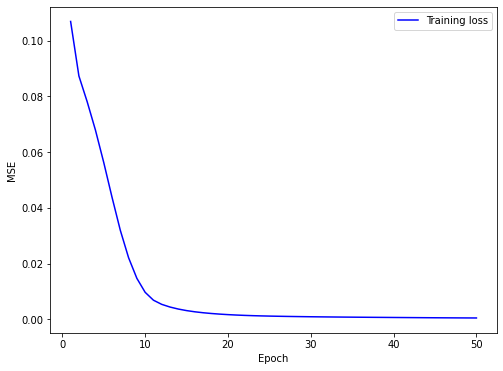

In [27]:
hitstory_loss = detector2.history_train_loss
n = len(hitstory_loss)

plt.figure(figsize=(8, 6))
x = np.arange(1, n+1)
plt.plot(x, hitstory_loss, c='blue', label='Training loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.show()

In [28]:
mse = detector1.score(X_val)
print('MSE training set: {:.6f}, validation set: {:.6f}'.format(detector1.history_train_loss[-1], mse))

mse = detector2.score(X_val)
print('MSE training set: {:.6f}, validation set: {:.6f}'.format(detector2.history_train_loss[-1], mse))

MSE training set: 0.001713, validation set: 0.001690
MSE training set: 0.000480, validation set: 0.000421


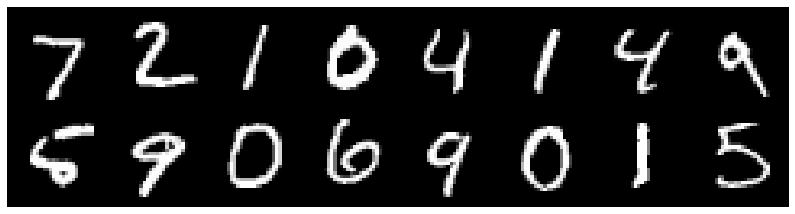

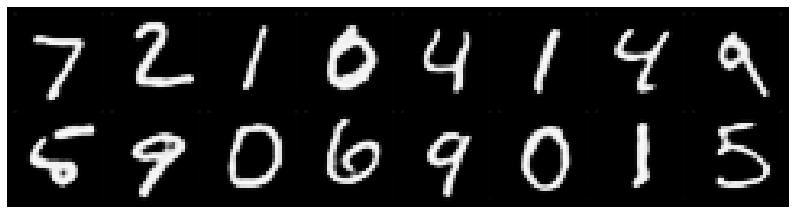

In [29]:
X_test_ae = detector1.predict(X_test)

grid_image = make_grid(torch.from_numpy(X_test[:16])).permute(1, 2, 0).detach().numpy()
plt.figure(figsize=(14, 4))
plt.imshow(grid_image)
plt.axis('off')
plt.show()

grid_image_ae = make_grid(torch.from_numpy(X_test_ae[:16])).permute(1, 2, 0).detach().numpy()
plt.figure(figsize=(14, 4))
plt.imshow(grid_image_ae)
plt.axis('off')
plt.show()

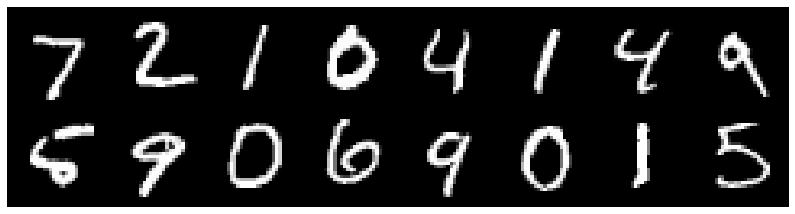

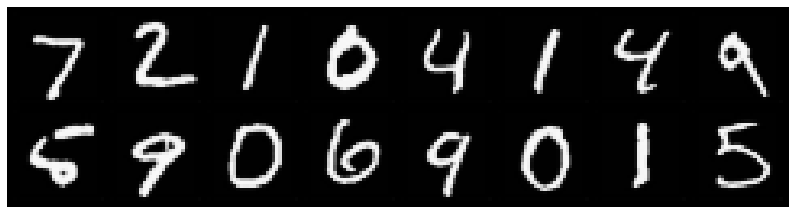

In [30]:
X_test_ae = detector2.predict(X_test)

grid_image = make_grid(torch.from_numpy(X_test[:16])).permute(1, 2, 0).detach().numpy()
plt.figure(figsize=(14, 4))
plt.imshow(grid_image)
plt.axis('off')
plt.show()

grid_image_ae = make_grid(torch.from_numpy(X_test_ae[:16])).permute(1, 2, 0).detach().numpy()
plt.figure(figsize=(14, 4))
plt.imshow(grid_image_ae)
plt.axis('off')
plt.show()

In [31]:
detector1.search_threshold(X_val, fp=0.001, update=True)

0.02969033

In [32]:
X_ae = detector1.predict(X_val)

In [33]:
diff = np.abs(X_val - X_ae)
diff = diff.reshape(diff.shape[0], -1)
scores = np.mean(diff, axis=1)
scores = np.sort(scores)
fp = 0.001
index = int(np.round((1-fp) * len(X_val)))
scores[index]

0.02969033

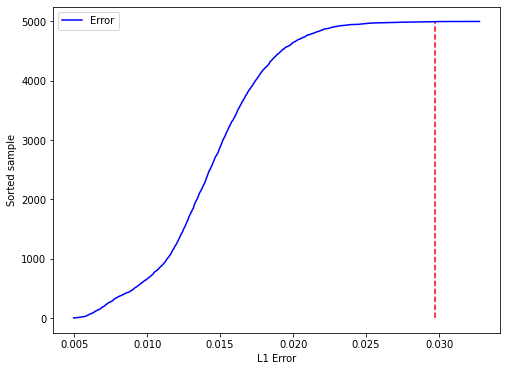

In [34]:
plt.figure(figsize=(8, 6))
y_ = np.arange(1, len(scores)+1)
plt.plot(scores, y_, c='blue', label='Error')
plt.vlines(scores[index], 0, 5000, colors='red', linestyles='dashed')
plt.legend()
plt.xlabel('L1 Error')
plt.ylabel('Sorted sample')
plt.show()

In [35]:
detector2.search_threshold(X_val, fp=0.001, update=True)

0.0018068047

In [36]:
X_ae = detector2.predict(X_val)

In [37]:
diff = np.abs(X_val - X_ae)
diff = diff.reshape(diff.shape[0], -1)
scores = np.mean(np.power(diff, 2), axis=1)
scores = np.sort(scores)
fp = 0.001
index = int(np.round((1-fp) * len(X_val)))
scores[index]

0.0018068047

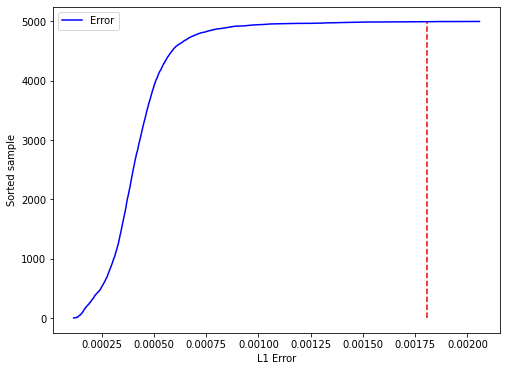

In [38]:
plt.figure(figsize=(8, 6))
y_ = np.arange(1, len(scores)+1)
plt.plot(scores, y_, c='blue', label='Error')
plt.vlines(scores[index], 0, 5000, colors='red', linestyles='dashed')
plt.legend()
plt.xlabel('L1 Error')
plt.ylabel('Sorted sample')
plt.show()

In [39]:
print(len(X_val))
results = detector1.detect(X_val)
print('False positive in validation set', len(np.where(results == True)[0]))

print(len(X_benign))
results = detector1.detect(X_benign)
print('False positive in test set', len(np.where(results == True)[0]))

results = detector1.detect(X_adv)
print('Blocked adversarial examples', len(np.where(results == True)[0]))

5000
False positive in validation set 4
2000
False positive in test set 2
Blocked adversarial examples 2000


In [40]:
print(len(X_val))
results = detector2.detect(X_val)
print('False positive in validation set', len(np.where(results == True)[0]))

print(len(X_benign))
results = detector2.detect(X_benign)
print('False positive in test set', len(np.where(results == True)[0]))

results = detector2.detect(X_adv)
print('Blocked adversarial examples', len(np.where(results == True)[0]))

5000
False positive in validation set 4
2000
False positive in test set 0
Blocked adversarial examples 2000


In [41]:
autoencoder3 = Autoencoder2(n_channel=1)
detector3 = MagNetDetector(
    encoder=autoencoder3,
    classifier=model,
    lr=0.001,
    batch_size=256,
    weight_decay=1e-09,
    x_min=0.0,
    x_max=1.0,
    noise_strength=0.025,
    algorithm='prob',
    p=None,
    device=device)
detector3.fit(X_train, epochs=50, disable_progress_bar=False)

100%|██████████| 50/50 [00:36<00:00,  1.38it/s]


In [42]:
detector3.search_threshold(X_val, fp=0.001, update=True)

0.0010474634

In [43]:
print(len(X_val))
results = detector3.detect(X_val)
print('False positive in validation set', len(np.where(results == True)[0]))

print(len(X_benign))
results = detector3.detect(X_benign)
print('False positive in test set', len(np.where(results == True)[0]))

results = detector3.detect(X_adv)
print('Blocked adversarial examples', len(np.where(results == True)[0]))

5000
False positive in validation set 4
2000
False positive in test set 0
Blocked adversarial examples 1893


In [44]:
reformer1 = MagNetNoiseReformer(noise_strength=0.025)
X_noisy = reformer1.reform(X_adv)
pred_noisy = np.argmax(classifier.predict(X_noisy), axis=1)

accuracy = np.sum(pred_adv == y_true) / float(len(pred_adv))
print("Model accuracy on advsarial examples: {:.4f}%".format(accuracy * 100))

accuracy = np.sum(pred_noisy == y_true) / float(len(pred_noisy))
print("Model accuracy on noisy samples: {:.4f}%".format(accuracy * 100))

Model accuracy on advsarial examples: 0.5500%
Model accuracy on noisy samples: 0.7000%


In [45]:
reformer2 = MagNetAutoencoderReformer(encoder=autoencoder1, batch_size=512, device=device)
X_reformed = reformer2.reform(X_adv)

pred_reformed = np.argmax(classifier.predict(X_reformed), axis=1)

accuracy = np.sum(pred_adv == y_true) / float(len(pred_adv))
print("Model accuracy on advsarial examples: {:.4f}%".format(accuracy * 100))

accuracy = np.sum(pred_noisy == y_true) / float(len(pred_reformed))
print("Model accuracy on encoded samples: {:.4f}%".format(accuracy * 100))

Model accuracy on advsarial examples: 0.5500%
Model accuracy on encoded samples: 0.7000%


In [46]:
# Testing save and load
detector1.save(PATH_DETECTOR)

In [47]:
autoencoder = Autoencoder1(n_channel=1)
detector = MagNetDetector(encoder=autoencoder)
detector.load(PATH_DETECTOR)

In [48]:
print(len(X_benign))
results = detector.detect(X_benign)
print('False positive in test set', len(np.where(results == True)[0]))

results = detector.detect(X_adv)
print('Blocked adversarial examples', len(np.where(results == True)[0]))

2000
False positive in test set 2
Blocked adversarial examples 2000


In [49]:
# Testing MagNetOperator
operator = MagNetOperator(
    classifier=model,
    detectors=[detector1, detector2],
    reformer=reformer1,
    batch_size=512,
    device=device)

In [50]:
# Testing on adversarial examples
X_reformed, labels = operator.detect(X_adv)
pred = np.argmax(classifier.predict(X_reformed), axis=1)
accuracy = np.sum(pred == y_true) / float(len(pred))

print(X_reformed.shape, labels.shape)
print("Model accuracy on reformed samples: {:.4f}%".format(accuracy * 100))
print('Blocked samples:', len(np.where(labels == True)[0]))

(2000, 1, 28, 28) (2000,)
Model accuracy on reformed samples: 0.7000%
Blocked samples: 2000


In [51]:
# Testing on benign samples
X_reformed, labels = operator.detect(X_benign)
pred = np.argmax(classifier.predict(X_reformed), axis=1)
accuracy = np.sum(pred == y_true) / float(len(pred))

print(X_reformed.shape, labels.shape)
print("Model accuracy on reformed samples: {:.4f}%".format(accuracy * 100))
print('Blocked samples:', len(np.where(labels == True)[0]))

(2000, 1, 28, 28) (2000,)
Model accuracy on reformed samples: 99.9500%
Blocked samples: 2


In [52]:
# Create a test set by combining adversarial examples and benign samples
X_mixed = np.concatenate((X_adv, X_benign))
y_label_mixed = np.concatenate((y_true, y_true))
# adversarial examples = 1, benign samples = 0
y_adv_mixed = np.concatenate((np.ones_like(y_true), np.zeros_like(y_true)))

print(X_mixed.shape, y_label_mixed.shape, y_adv_mixed.shape)

(4000, 1, 28, 28) (4000,) (4000,)


In [53]:
X_reformed, labels = operator.detect(X_mixed)
pred = np.argmax(classifier.predict(X_reformed), axis=1)
accuracy = np.sum(pred == y_label_mixed) / float(len(pred))

print(X_reformed.shape, labels.shape)
print("Model accuracy on reformed samples: {:.4f}%".format(accuracy * 100))
print('Blocked samples:', len(np.where(labels == True)[0]))

(4000, 1, 28, 28) (4000,)
Model accuracy on reformed samples: 50.2750%
Blocked samples: 2002


In [54]:
print(operator.score(X_benign, y_true, np.zeros_like(y_true)))
print(operator.score(X_adv, y_true, np.ones_like(y_true)))
print(operator.score(X_mixed, y_label_mixed, y_adv_mixed))

0.999
1.0
0.9995
